In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import seaborn as sns

import scipy.stats as stats
from scipy.special import gamma as Gamma
from scipy.stats import invgamma,t
from statsmodels.sandbox.distributions.multivariate import multivariate_t_rvs

from arch import arch_model
from arch.univariate import ConstantMean, GARCH, StudentsT

In [59]:
df = pd.read_csv('INTC.csv')
df.index = df['Date']
df = df.drop(columns=['Open', 'High', 'Low','Close','Volume'])
df = df.rename(columns={'Adj Close': 'price'})
df['returns'] = np.log(df['price']).diff()
dates = df.Date[1:] 
display(df.head())

,Date,price,returns
Date,,,
2009-06-08,2009-06-08,11.656049,NaN
2009-06-09,2009-06-09,12.022135,0.030924
2009-06-10,2009-06-10,12.051419,0.002433
2009-06-11,2009-06-11,11.970881,-0.006705
2009-06-12,2009-06-12,11.941595,-0.002449


In [60]:
am = ConstantMean(df['returns'][1:])
am.volatility = GARCH(1, 0, 1)
am.distribution = StudentsT()

res = am.fit(disp = 'off', update_freq = 7)

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [61]:
res

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      returns   R-squared:                      -1.143
Mean Model:                   Constant Mean   Adj. R-squared:                 -1.143
Vol Model:                            GARCH   Log-Likelihood:                1042.94
Distribution:      Standardized Student's t   AIC:                          -2075.87
Method:                  Maximum Likelihood   BIC:                          -2046.80
                                              No. Observations:                 2474
Date:                      Sun, Jul 14 2019   Df Residuals:                     2469
Time:                              08:01:32   Df Model:                            5
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------

In [62]:
GARCH_param = pd.DataFrame({'Asset' : 'Stock', 'omega' : [res.params['omega']],
                            'alpha' : [res.params['alpha[1]']],
                            'beta' : [res.params['beta[1]']],
                            'nu' : [res.params['nu']]                            
                           })

GARCH_param.set_index('Asset', inplace = True)

display(GARCH_param)
res.summary()

,omega,alpha,beta,nu
Asset,,,,
Stock,0.0,0.985204,0.014677,49.515688


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                      returns   R-squared:                      -1.143
Mean Model:                   Constant Mean   Adj. R-squared:                 -1.143
Vol Model:                            GARCH   Log-Likelihood:                1042.94
Distribution:      Standardized Student's t   AIC:                          -2075.87
Method:                  Maximum Likelihood   BIC:                          -2046.80
                                              No. Observations:                 2474
Date:                      Sun, Jul 14 2019   Df Residuals:                     2469
Time:                              08:01:32   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu            -0.0158  1.324e-03    -11.919  9.425e-33 [-1.837e-02,-1.318e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0000  2.383e-07      0.000      1.000 [-4.670e-07,4.670e-07]
alpha[1]       0.9852  9.320e-02     10.571  4.075e-26      [  0.803,  1.168]
beta[1]        0.0147  3.598e-03      4.079  4.531e-05  [7.624e-03,2.173e-02]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu            49.5157      4.049     12.228  2.198e-34 [ 41.579, 57.452]
========================================================================

Covariance estimator: robust

WARNING: The optimizer did not indicate successful convergence. The message was
Inequality constraints incompatible. See convergence_flag.
"""

In [63]:
#activate sns
%matplotlib notebook 

In [64]:
def plotfigure(x,title,xlabel,linewdth):
    
    fig, ax = plt.subplots()
    
    ax.set_xlabel('Date')
    ax.set_ylabel(xlabel)
    ax.set_title(title)
    
    plt.rcParams["figure.figsize"] = [10,6]
        
    ax.plot('Date', x, data=df, linewidth=linewdth)
    
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%Y')

    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)

    df['Date'] = pd.to_datetime(df['Date'])
    
    datemin = np.datetime64(str(df['Date'][0]), 'Y')
    datemax = np.datetime64(df['Date'][-1], 'Y') + np.timedelta64(1, 'Y')
    ax.set_xlim(datemin, datemax)

    
    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    ax.grid(True)
    

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()
        
    plt.savefig(title+".png")
    return;

<IPython.core.display.Javascript object>


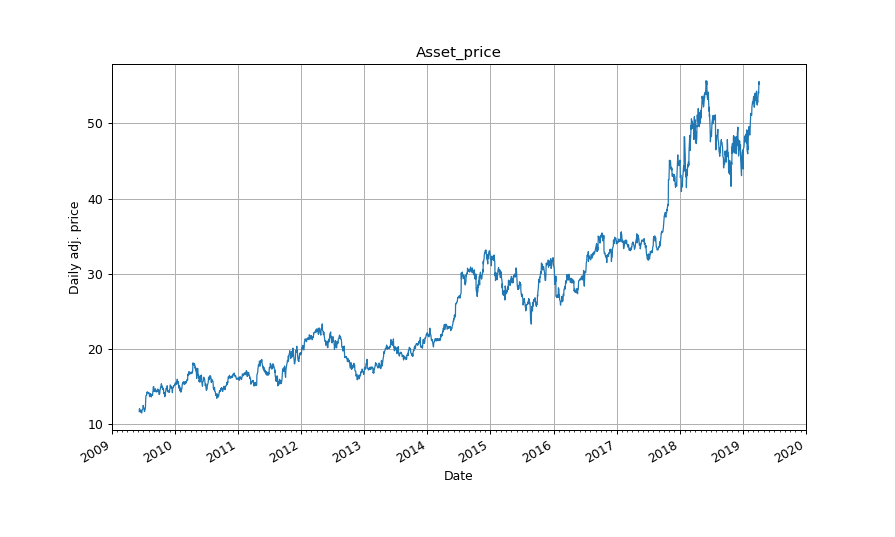

In [66]:
#to be run twice at every new launch for a nice display (will display an error for the first run)

plotfigure('price','Asset_price','Daily adj. price',linewdth = 1)

<IPython.core.display.Javascript object>


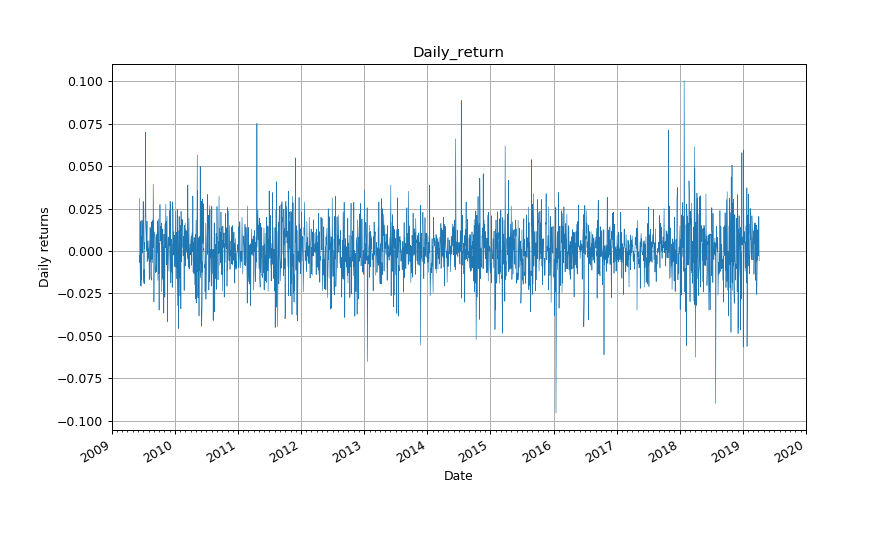

In [11]:
plotfigure('returns','Daily_return','Daily returns',linewdth = 0.5)

We will consider the augmented model of the log-returns process \{$y_t$, $t\in \mathcal{Z}$\} (Geweke, 1993) of a GARCH(1,1) with Student-t innovations, for $t = 1, \dots, T$:

$$    y_t = \epsilon_t(\dfrac{\nu -2}{\nu}\eta_t h_t)^{1/2} $$

The parameter $\dfrac{\nu -2}{\nu}$ is a scaling factor which ensures the conditional variance of $y_t$ to be $h_t$.

where $\epsilon_t$ is a sequence of $i.i.d.$ variables $\sim$ ${\mathcal{N}}(0, 1)$, 

where $\eta_t$ is a sequence of $i.i.d.$ variables $\sim$ ${\mathcal{IG}}(\dfrac{\nu}{2}, \dfrac{\nu}{2})$, and


$$ h_t = \omega + \alpha \cdot y^2_{t-1} + \beta \cdot h_{t-1}$$

for $\omega > 0$; $\alpha,\beta \geq 0$; ${\mathcal{N}}(0, 1)$ denotes the standard normal distribution, ${\mathcal{IG}}$ the inverted gamma distribution. The restriction on the GARCH parameters $\omega$, $\alpha$, $\beta$ guarantee the conditional variance's positivity.

The term $(\alpha + \beta)$ is the degree of persistence in the autocorrelation of the squares which controls the intensity of the clustering in the variance process. With a value close to one, past shocks and past variances will have a longer impact on the future conditional variance.


In [67]:
GARCH_param['alpha'][0]+GARCH_param['beta'][0]

0.9998804004375589

Define: $\psi \doteq (\omega,\alpha,\beta,\nu)$.    
We can define the T x T diagonal matrix:

$$\Sigma \doteq \Sigma(\psi,\omega)=diag\left(\eta_t\dfrac{\nu-2}{\nu}h_t(\omega,\alpha,\beta)\right)$$ 

for $t=1,\dots,T$

We can express the likelihood of $(\psi,\eta)$ as: 

$$\mathcal{L}(\psi,\omega|y) \propto (det \Sigma)^{-1/2}exp[-\dfrac{1}{2}y'\Sigma^{-1}y]$$

Best practices:

Work with logs for every function for numerical stability.
We divise into many functions for easier unit testing.

To ensure conditional variance and likelihood to be well-behaved, we need to enforce the following constraints:
$\omega>0 ; \alpha \geq 0; \beta  \geq  0; \omega + \alpha < 1$.

We chose normal priors over $\omega$, $\alpha$, $\beta$: 

$$p(\omega)\propto \phi_{\mathcal{N}}(\omega | \mu_0, \Sigma_0) \cdot \mathbb{1}_{\omega>0}$$

$$p(\alpha)\propto \phi_{\mathcal{N}}(\alpha | \mu_0, \Sigma_0) \cdot \mathbb{1}_{\alpha \geq 0}$$

$$p(\beta)\propto \phi_{\mathcal{N}}(\beta | \mu_0, \Sigma_0) \cdot \mathbb{1}_{\beta  \geq  0}$$

The prior distribution on $\eta$ conditional on $\nu$ is found by noting that the components $\eta_t$ are $i.i.d.$ distributed from the inverted gamma density, which yields: 

$$log(p(\eta|\nu))=\dfrac{T\nu}{2}log(\dfrac{\nu}{2})-T\cdot log(\Gamma(\dfrac{\nu}{2}))-(\dfrac{\nu}{2}+1)
\sum_{t=1}^T log(\eta_t)-\dfrac{1}{2}\sum_{t=1}^T\dfrac{\nu}{\eta_t}$$ 


Following (Deschamps,2006) in the choice of the prior distribution on the degrees of freedom parameter $\nu$, our prior is a translated exponential with parameters $\lambda > 0$ and $\delta ≥ 2$:

$$ p(\nu)= \lambda exp[-\lambda(\nu-\delta)] \cdot \mathbb{1}_{\nu>\delta}$$

For large values of $\lambda$, the mass of the prior is concentrated in the neighborhood of $\delta$ and a constraint on the degrees of freedom can be imposed in this manner. Normality of the errors is assumed when $\delta$ is chosen large.

In [68]:
#we use truncated normal priors on the GARCH parameters alpha ; beta ; omega
def log_gaussian_prior_omega(mu_0=0, sigma_0=0.0005):
    ans = lambda omega: -0.5 * np.log(2 * np.pi)\
                        - np.log( sigma_0 )\
                        - 0.5 * (omega - mu_0)**2 / sigma_0**2 \
                        if omega>0 else 0
    return ans

def log_gaussian_prior_alpha(mu_0=0.05, sigma_0=0.05):
    ans = lambda alpha: -0.5 * np.log(2 * np.pi)\
                        - np.log( sigma_0 )\
                        - 0.5 * (alpha - mu_0)**2 / sigma_0**2\
                        if alpha>0 else 0
    return ans

def log_gaussian_prior_beta(mu_0=0.1, sigma_0=0.2):
    ans = lambda beta: -0.5 * np.log(2 * np.pi)\
                        - np.log( sigma_0 )\
                        - 0.5 * (beta - mu_0)**2 / sigma_0**2\
                        if beta>0 else 0
    return ans

def log_inverted_gamma_prior_eta(nu=GARCH_param['nu'][0]): #prior is MLE value ; should have minor influence 
    T = df.shape[0]
    ans = lambda eta: T*nu*0.5*np.log(nu/2)-T*np.log(Gamma(nu/2)) - (0.5*nu+1)*sum(np.log(eta)) - 0.5*T*nu*(1/sum(eta))
    return ans

def log_translated_exponential_nu(lambd=1,delta=1): #flat priors over the distribution's parameters
    ans = lambda nu: np.log(lambd) - (lambd*(nu-delta)) if nu>delta else 0
    return ans

In [69]:
def log_joint_prior():
    log_prior_omega    = log_gaussian_prior_omega()
    log_prior_alpha    = log_gaussian_prior_alpha()
    log_prior_beta     = log_gaussian_prior_beta()
    log_prior_eta      = log_inverted_gamma_prior_eta()
    log_prior_nu       = log_translated_exponential_nu()
    
    ans = lambda omega, alpha, beta, eta, nu: log_prior_omega(omega)\
                                              +log_prior_alpha(alpha)\
                                              +log_prior_beta(beta)\
                                              +log_prior_eta(eta)\
                                              +log_prior_nu(nu)
    return ans

In [70]:
#this aims to remove replace y_t values equal to 0 by the lowest value in the serie  
logret = df['returns'].tolist()
logret[0] = 0.5
logret=np.array(logret[1:])
print(np.nan in logret)

False


We fill in the vector of the conditional variance: $$h_t = \omega + \alpha y_{t-1}^2 + \beta h _{t-1}$$

In [71]:
def h(omega, alpha ,beta): 
    logret = df['returns'].tolist()
    logret[0] = lowest_value_in_yt #arbitrary value, otherwise we would have h[0]=0 with which we would try to divide y_t by later on
    logret = np.array(logret)
    T = len(logret)
    
    #initialize vector
    h = np.zeros(T)

    for t in range(T-1):
        h[t+1]= omega + alpha * logret[t]**2 + beta * h[t]
    h = h[1:]
    return h

$$log(p(\eta|\nu))=\dfrac{T\nu}{2}log(\dfrac{\nu}{2})-T\cdot log(\Gamma(\dfrac{\nu}{2}))-(\dfrac{\nu}{2}+1)
\sum_{t=1}^T log(\eta_t)-\dfrac{1}{2}\sum_{t=1}^T\dfrac{\nu}{\eta_t}$$ 


In [72]:
def eta_sampling(nu): 
    T = logret.shape[0]
    
    eta = invgamma.rvs(nu, size=(T,1))
        
    return eta

In [73]:
def eta_posterior(nu,eta): 
    T = df.shape[0]
    
    p = T*nu*0.5*np.log(nu/2)-T*np.log(Gamma(nu/2)) - (0.5*nu+1)*sum(np.log(eta)) - 0.5*T*nu*(1/sum(eta))

    return p

In [74]:
#set of priors from MLE

logret = df['returns'].tolist()
logret = np.array(logret[1:])

omega = GARCH_param['omega'][0]
alpha = GARCH_param['alpha'][0]
beta = GARCH_param['beta'][0]
nu = GARCH_param['nu'][0]

#if ARCH has incompatibilities, work with the hardcoded values
#GARCH_param = pd.DataFrame(columns=['omega',
#                                    'alpha',
#                                    'beta',
#                                    'nu'
#                                   ],index = ['values'])
#GARCH_param['omega'][0] = 0
#GARCH_param['alpha'][0] = 0.985204
#GARCH_param['beta'][0] = 0.014677
#GARCH_param['nu'][0] = 49.515688

print('0')

0


The likelihood function applied to our GARCH(1,1) with students innovations yields:

$$\Sigma \doteq \Sigma(\psi,\omega)=diag\left(\eta_t\dfrac{\nu-2}{\nu}h_t(\omega,\alpha,\beta)\right)$$ 

for $t=1,\dots,T$

We can express the likelihood of $(\psi,\eta)$ as: 

$$\mathcal{L}(\psi,\omega|y) \propto (det \Sigma)^{-1/2}exp[-\dfrac{1}{2}y'\Sigma^{-1}y]$$

$$log(\mathcal{L}(\psi,\omega|y)) \propto -\dfrac{1}{2}log(det(\eta_t\dfrac{\nu-2}{\nu}h_t)-\dfrac{1}{2}\dfrac{y_t^2\nu}{\eta_t(\nu-2)h_t}$$

We define the log posterior as:

$$log(p(\theta | y)) \propto log(L(\theta|y))+ log(p(\theta)) \$$

In [75]:
def log_posterior(y,omega,alpha,beta,eta,nu):
    log_prior = log_joint_prior()
    ans = log_prior(omega,alpha,beta,eta,nu)
    
    ht = h(omega,alpha,beta)

    log_normal_likelihood = -(1/2)*np.log( ((nu-2)/nu)*eta.T@ht)\
                        -(1/2)*((nu*logret.T@logret)/((nu-2)*eta.T@ht))

    ans += sum(log_normal_likelihood)

    return ans

In [76]:
def log_posterior_nu(y,omega,alpha,beta,eta,nu):
    log_prior = log_joint_prior()
    ans = log_prior(omega,alpha,beta,eta,nu)
    
    ht = h(omega,alpha,beta)

    log_normal_likelihood = -(1/2)*np.log( ((nu-2)/nu)*eta.T@ht)\
                            -(1/2)*((nu*logret.T@logret)/((nu-2)*eta.T@ht))
    ans += sum(log_normal_likelihood)

    return ans
    

In [77]:
#we create a dataframe which will contain all MH simulations and their results
#this will allow to tune the step size and provide a cost overview

all_simulations_so_far = pd.DataFrame(columns=['# batches', #number of batches of nsims to be run
                                                 'sims / batch', #number of simulations ran per batch of sims
                                                 'time_per_MH', #total time taken for the whole MH computation (# batches*nsims)
                                                 'scale', #scale (a.k.a. stepsize) affecting all variables
                                                 'array_stepsize', #stepsize affected to each var for more detailed tuning
                                                 'avg_omega / MH_sampling', #average value of omega over all batches
                                                 'avg_alpha / MH_sampling', #average value of alpha over all batches
                                                 'avg_beta / MH_sampling',  #average value of beta over all batches
                                                 'Skip_rate', #refers to the rate where the GARCH constraints were not respected
                                                 'U>R_rate', #refers to the rate where the uniform random variable U is superior to the ratio R
                                                 'A_rate', #acceptance rate U <= R
                                              ],index=range(1,1))
all_simulations_so_far.index.name = 'MH_sampling_id'

In [78]:
def theta_proposal(omega_i,alpha_i,beta_i, scale,omega_stepsize,alpha_stepsize,beta_stepsize):   

    theta_i = np.array([omega_i,alpha_i,beta_i]) 
    
    dim = theta_i.shape[0] #dimension

    #Proposal: Markov-chain transition density h(\theta_{n+1}|\theta_n) ~ N_{loc=mu ; scale = sigma} ; 
    
    #since we only want to tune the scale (stepsize), choose flat priors on other hyperparameters of the model
    sigma = 1
    mu = 1 
    
    zeta = np.random.normal(loc=mu, scale=sigma, size=dim)    
    
    #size of the eta_n function of the defined scale (i.e. stepsize lambda)
    stepsize = np.diag(np.ones(dim))
    
    stepsize = stepsize*scale
    
    array_stepsize = np.array([omega_stepsize,alpha_stepsize,beta_stepsize])
    
    stepsize[0][0] *= omega_stepsize #omega stepsize coefficient
    stepsize[1][1] *= alpha_stepsize #alpha stepsize coefficient
    stepsize[2][2] *= beta_stepsize #beta stepsize coefficient
    
    # @ sign yields the same result as np.dot() for this matrix shape
    theta = theta_i + stepsize@zeta

    #Note that we will enforce the GARCH conditions in the MH algorithm
    return theta,array_stepsize

In [79]:
def metropolis_hastings(nsims, nb_of_times_we_run_nsims, scale, data, stepsize_theta): 
    start = time. time()
    
    #consider MLE estimates as starting values
    omega_i = GARCH_param['omega'][0]
    alpha_i = GARCH_param['alpha'][0]
    beta_i = GARCH_param['beta'][0]
    nu_i=GARCH_param['nu'][0]
    
    delta = 1
    
    #group the GARCH parameters into a variable named theta_i
    theta_i = np.array([omega_i,alpha_i,beta_i])
    
    #constitute a numpy array of all thetas 
    all_thetas = np.array(theta_i)
    
    #temporary value used if we have nb_of_times_we_run_nsims > 1
    theta_init = theta_i

    #in this model, the log-likelihood is much 10^5 times bigger than the log prior
    #while normally not needed, we scale the Importance Sampling weights down, to have sizable weights
    #we found the minimum K value by sampling nu 100,000 times and taking the max of the resulting ratios
    #mathematical rigor would require to find the minimum K value, theoretically
    K_min_value = 301856 
    
    
    #initialiaze dataframe which will include all relevant specifications
    rates = pd.DataFrame(columns=['# simulations',
                                  'Time for 1 batch of sims',
                                  'Skip_rate',
                                  'U>R_rate',
                                  'A_rate'],
                        index=range(1,nb_of_times_we_run_nsims+1))
    rates.index.name = 'batch of nsims id'
    
    #this dataframe gathers summary statistics for a MH algorithm run (# batches * nsims)
    summary = pd.DataFrame(columns=['Total MH algo time',
                                    'Avg time per batch of sims (in s.)',
                                    'array_stepsize'
                                   ],
                           index=['values'])

    
    #dataframe containing all_thetas (the latter being an array of arrays), in each cell
    df_of_all_thetas = pd.DataFrame(columns=['All thetas'], 
                    index=range(1,nb_of_times_we_run_nsims+1))
    
    
    print('********************** LAUNCHING SAMPLING PROCEDURE **********************')
    
    
    #if nb_of_times_we_run_nsims > 1: we make nb_of_times_we_run_nsims*nsims simulations, 
    #results are averaged over all computations
    for k in range(1,nb_of_times_we_run_nsims+1): 
    
        #(re-)initialize all counts and rates at each batch
        count = 0            #count value incremented when U <= R
        skip = 0             #count value incremented when constraints on GARCH parameters are unsatisfied
        skipping_rate=0
        next_iter = 0        #count value incremented when U > R
        next_iter_rate = 0 
        acceptance_rate = 0
        all_thetas = theta_init #re-initiliaze the all_thetas array with the initial MLE values
        intra_sim_time_start = time. time() #will allow to compute the time taken for one batch of nsims
        all_thetas = np.array([omega_i,alpha_i,beta_i])
           
        for n in range(nsims):           
                        
            #create theta_prop
            theta_prop,array_stepsize = theta_proposal(*theta_i,scale,*stepsize_theta)
                    
            #if GARCH constraints not satisfied, iterate 
            if not (theta_prop[0]>0 and theta_prop[1]>=0 and theta_prop[2] >=0 and (theta_prop[0]+theta_prop[1])<1):
                skip +=1
                continue #iterate to next simulation
                
                
            ######## Importance Sampling algorithm ########

            
            #below is the number of independent and identically distributed samples of nu that we generate
            nb_iid_samples_to_gen = 10 

            eta_i_array = eta_sampling(nu_i)   #sample the etas from the inverted gamma distribution 

            #dataframe to store the values used for the weights computation
            weights_df = pd.DataFrame(columns=['nu',
                                               'target_f(nu|d)',
                                               'h(nu)',
                                               'w_i',
                                               'weighted_samples',
                                               'weighted_sum'
                                              ])

            #below, we generate the nu variable from a random exponential
            nu_prop = np.random.exponential(scale=nu_i-delta, size=nb_iid_samples_to_gen) 

            for d,j in enumerate(nu_prop):
                #the following condition enforces the constraints imposed on nu 
                if not j>2: 
                    nu_prop[d] = nu_i

            #proposal of h(\nu)
            log_proposal_nu = log_translated_exponential_nu()

            for i,value in enumerate(nu_prop):
                log_posterior_nu_value = log_posterior_nu(logret, *theta_prop, eta_i_array,  value)
                log_proposal_nu_value = log_proposal_nu(value)
                weights_df = weights_df.append({'nu':value,
                                               'target_f(nu|d)':log_posterior_nu_value,
                                               'h(nu)':log_proposal_nu_value,
                                               'w_i':float((log_posterior_nu_value-log_proposal_nu_value)/301856)
                                               }, ignore_index=True)

            #we want to recover nu's weighted average
            weights_df['weighted_samples'] = (weights_df['w_i']*weights_df['nu'])/weights_df['w_i'].sum()
            
            nu_i=weights_df['weighted_samples'].sum()
            
            ######## Importance Sampling algorithm ########
            
            
            #implementing the acceptance decision within the MH algorithm eases unit testing
            f_theta_proposal_given_data = log_posterior(y,*theta_prop,eta_i_array,nu_i)             
            f_theta_i_given_data = log_posterior(y,*theta_i,eta_i_array,nu_i)

            log_ratio = f_theta_proposal_given_data - f_theta_i_given_data
            ratio = np.exp(log_ratio)           
            R = min(ratio,1)

            u = np.random.uniform(0, 1, 1)

            if u <= R:
                #if we do have u<= R, we set the theta proposal as our new theta_i
                theta_i = theta_prop 
        
                #we stack the theta_i into the array of thetas
                all_thetas = np.vstack((all_thetas,theta_i)) 
                count += 1 
           
            else:
                #stack the current theta_i (hence, next sim will discard the current theta_prop)
                all_thetas = np.vstack((all_thetas,theta_i)) 
                next_iter += 1
                continue
        
        #compute each rate
        acceptance_rate = count/nsims
        skipping_rate = skip /nsims
        next_iter_rate = next_iter /nsims

        #record the thetas obtained from a batch, into a cell of df_of_all_thetas dataframe
        #it is therefore an array into a cell
        df_of_all_thetas['All thetas'][k]=all_thetas
        
        #store each rate and the number of simulations
        rates['# simulations'][k] = nsims
        rates['Skip_rate'][k] = skipping_rate
        rates['U>R_rate'][k] = next_iter_rate
        rates['A_rate'][k] = acceptance_rate
        
        #compute the time taken for one batch and store it
        intra_sim_time_end = time. time()
        rates['Time for 1 batch of sims'][k] = intra_sim_time_end - intra_sim_time_start
        
        print('Time taken for batch number ',
              k,' is: ',
              np.around(rates['Time for 1 batch of sims'][k],4))
        
    #compute the average rates over the number of batches of nsims
    summary['Mean Skip_rate'] = rates['Skip_rate'].mean()
    summary['Mean U>R_rate'] = rates['U>R_rate'].mean() 
    summary['Mean A_rate'] = rates['A_rate'].mean()
    
    #compute the total time taken for the MH algorithm
    end = time. time()
    seconds = end - start
    minutes, seconds = divmod(seconds, 60)
    minutes = int(minutes)
    seconds = int(seconds)
    z = "%smin %ss" % (minutes,seconds) #total time taken to run # batches * nsims

    #store each time component into the summary statistics dataframe
    summary['Total MH algo time'] = z
    summary['Avg time per batch of sims (in s.)'] = seconds/nb_of_times_we_run_nsims
    summary['array_stepsize'][0] = array_stepsize

    
    return df_of_all_thetas,rates,summary,z

In [86]:
#aim: having (skipping_rate+next_iter_rate) to be roughly equal to 0.5,
#<=> aiming for an acceptance rate at 0.50 +/- 0.05 by the end of the simulation procedure

#since the scale affects all three theta_proposal variables, we leave it to 1 to allow for fine-tuning 
scale = 1 

y=logret

#number of batches of nsims we wish to run
nb_sims = 1

#values obtained by fine-tuning the stepsize
alpha_stepsize = 0.0048
beta_stepsize = 0.00002
omega_stepsize = 1e-09

#array containing the stepsizes affected
theta_stepsize = np.array([omega_stepsize,alpha_stepsize,beta_stepsize])

df_of_all_thetas,rates,summary,z = metropolis_hastings(nsims=10000,
                                                                nb_of_times_we_run_nsims = nb_sims,
                                                                scale=scale,
                                                                data=logret,
                                                                stepsize_theta=theta_stepsize)

********************** LAUNCHING SAMPLING PROCEDURE **********************
Time taken for batch number  1  is:  586.0451


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [87]:
# posterior_mean_computations dataframe gathers up the average and median GARCH parameters values 
# for each batch of n simulations ; hence has as many rows as the number of batches we computed

# posterior_mean_computations dataframe gathers up the average over all batches of n simulations

posterior_mean_computations = pd.DataFrame(columns=['means per sim batch',
                                                    'median per sim batch',
                                                     'avg omega value',
                                                     'avg alpha value',
                                                     'avg beta value',
                                                     'median omega value',
                                                     'median alpha value',
                                                     'median beta value'
                                                   ],
                        index=range(1,df_of_all_thetas.shape[0]+1))

posterior_mean_computations.index.name = 'batch of nsims id'

posterior_mean_approximation = pd.DataFrame(columns=['avg omega / batches of sims',
                                                     'avg alpha / batches of sims',
                                                     'avg beta / batches of sims'],
                                                     index=['values'])
#used to average over all batches of simulations
for i in range(1,df_of_all_thetas.shape[0]+1):
    
    #compute the mean and median of each GARCH parameter, for each theta
    posterior_mean_computations['means per sim batch'][i] = np.around(np.mean(df_of_all_thetas['All thetas'][i], axis = 0),6)
    posterior_mean_computations['median per sim batch'][i] = np.around(np.median(df_of_all_thetas['All thetas'][i], axis = 0),6)
    
variable_list=['omega','alpha','beta']

for variable in range(len(variable_list)):
    for sim_id in range(1,posterior_mean_computations.shape[0]+1):
        
        #if we set a step_size too big and a n_sims too low, 
        #we might get errors where a theta value would not be a tuple (i.e. a single value of float type)
        #in which case, it is safer not to include these values and iterate forward
        
        #compute the mean (for all thetas) of the mean of theta
        if ( type (posterior_mean_computations['means per sim batch'][sim_id] ) != np.float64 ):
            posterior_mean_computations['avg '+variable_list[variable]+' value'][sim_id] = posterior_mean_computations['means per sim batch'][sim_id][variable]
        else:
            continue
            
        #median
        if ( type (posterior_mean_computations['means per sim batch'][sim_id] ) != np.float64 ):
            posterior_mean_computations['median '+variable_list[variable]+' value'][sim_id] = posterior_mean_computations['means per sim batch'][sim_id][variable]
        else:
            continue
            
display(posterior_mean_computations)

#we now compute the average GARCH parameters over all batches of n simulations each
for variable in range(len(variable_list)):
    for sim_id in range(1,posterior_mean_computations.shape[0]+1):
        posterior_mean_approximation['avg '+variable_list[variable]+' / batches of sims'] = posterior_mean_computations['avg '+variable_list[variable]+' value'].mean()

posterior_mean_approximation['nb_batches'] = posterior_mean_computations.shape[0]
posterior_mean_approximation['nb_sims_per_batch'] = rates['# simulations'][1]
    
display(posterior_mean_approximation)

,means per sim batch,median per sim batch,avg omega value,avg alpha value,avg beta value,median omega value,median alpha value,median beta value
batch of nsims id,,,,,,,,
1,"[2e-06, 0.985648, 0.047893]","[2e-06, 0.987965, 0.048061]",2e-06,0.985648,0.047893,2e-06,0.985648,0.047893


,avg omega / batches of sims,avg alpha / batches of sims,avg beta / batches of sims,nb_batches,nb_sims_per_batch
values,0.000002,0.985648,0.047893,1,10000


In [88]:
#append the relevant statistics to our dataframe of all MH sampling done

all_simulations_so_far = all_simulations_so_far.append({'# batches' : rates.shape[0],
                                                        'sims / batch' : rates['# simulations'][1],
                                                        'time_per_MH' : summary['Total MH algo time'][0],
                                                        'scale' : scale,
                                                        'array_stepsize': summary['array_stepsize'][0],
                                                        'Skip_rate':summary['Mean Skip_rate'][0],
                                                        'U>R_rate':summary['Mean U>R_rate'][0],
                                                        'A_rate':summary['Mean A_rate'][0],
                                                        'avg_omega / MH_sampling':posterior_mean_approximation['avg omega / batches of sims'][0],
                                                        'avg_alpha / MH_sampling':posterior_mean_approximation['avg alpha / batches of sims'][0],
                                                        'avg_beta / MH_sampling':posterior_mean_approximation['avg beta / batches of sims'][0],
                                                       } , ignore_index=True)

print('The rates are averaged over the batches of simulations.')
all_simulations_so_far

The rates are averaged over the batches of simulations.


,# batches,sims / batch,time_per_MH,scale,array_stepsize,avg_omega / MH_sampling,avg_alpha / MH_sampling,avg_beta / MH_sampling,Skip_rate,U>R_rate,A_rate
0,1,1000,0min 59s,1,"[1e-09, 0.0048, 2e-05]",0.000000,0.984444,0.018092,0.2770,0.3940,0.3290
1,1,10000,9min 46s,1,"[1e-09, 0.0048, 2e-05]",0.000002,0.985648,0.047893,0.3262,0.3591,0.3147


In [89]:
#compare the MH values with the MLE values
GARCH_param

,omega,alpha,beta,nu
Asset,,,,
Stock,0.0,0.985204,0.014677,49.515688


In [90]:
#save the dataframe of all compuations, as a .csv file
all_simulations_so_far.to_csv('all_simulations_so_far.csv')

In [91]:
all_simulations_so_far

,# batches,sims / batch,time_per_MH,scale,array_stepsize,avg_omega / MH_sampling,avg_alpha / MH_sampling,avg_beta / MH_sampling,Skip_rate,U>R_rate,A_rate
0,1,1000,0min 59s,1,"[1e-09, 0.0048, 2e-05]",0.000000,0.984444,0.018092,0.2770,0.3940,0.3290
1,1,10000,9min 46s,1,"[1e-09, 0.0048, 2e-05]",0.000002,0.985648,0.047893,0.3262,0.3591,0.3147


In [92]:
#specifying the following lines allow sns activation
%matplotlib notebook

<IPython.core.display.Javascript object>


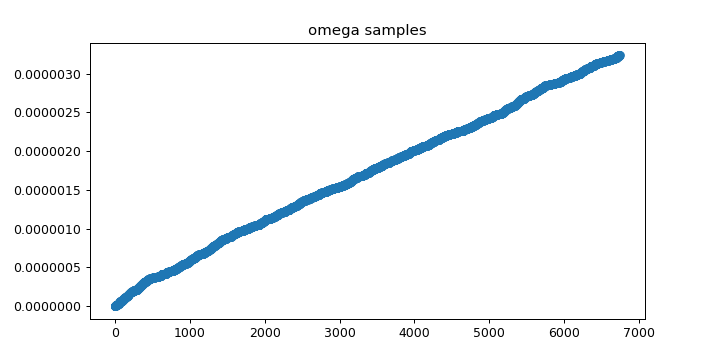

In [93]:
#scatterplot of each omega for all_thetas (one plot per batch)
plt.rcParams['figure.figsize'] = [8,4]
for i in range(0,df_of_all_thetas.shape[0]):
    
    plt.figure()
    plt.plot(df_of_all_thetas['All thetas'][i+1][:,0], 'o')
    title='omega samples'    
    plt.title(title)


<IPython.core.display.Javascript object>


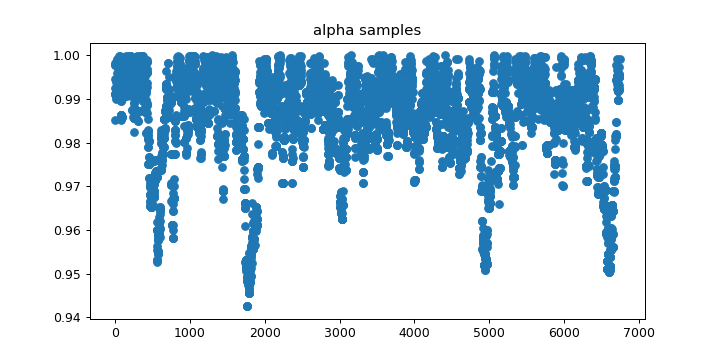

In [96]:
plt.rcParams['figure.figsize'] = [8,4]

for i in range(0,df_of_all_thetas.shape[0]):
    
    plt.figure()
    plt.plot(df_of_all_thetas['All thetas'][i+1][:,1], 'o')
    title='alpha samples'    
    plt.title(title)
    plt.savefig(title+'.png')

<IPython.core.display.Javascript object>


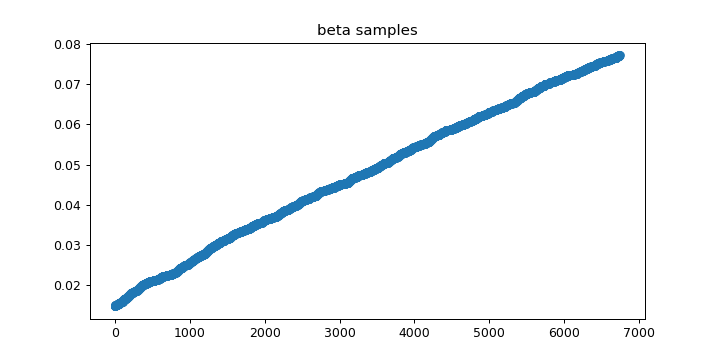

In [97]:
plt.rcParams['figure.figsize'] = [8,4]
for i in range(0,df_of_all_thetas.shape[0]):
    plt.figure()
    plt.plot(df_of_all_thetas['All thetas'][i+1][:,2], 'o')
    title='beta samples'    
    plt.title(title)
    


<IPython.core.display.Javascript object>


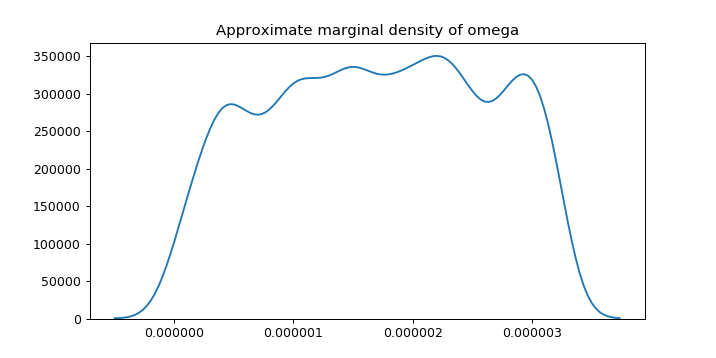

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [98]:
#omega density

plt.rcParams['figure.figsize'] = [8,4]
for i in range(0,df_of_all_thetas.shape[0]):
    
    plt.figure()
    sns.kdeplot(df_of_all_thetas['All thetas'][i+1][:,0])
    
    title='Approximate marginal density of omega'
    
    plt.title(title)
    plt.savefig(title+".png")
    

plt.show()

<IPython.core.display.Javascript object>


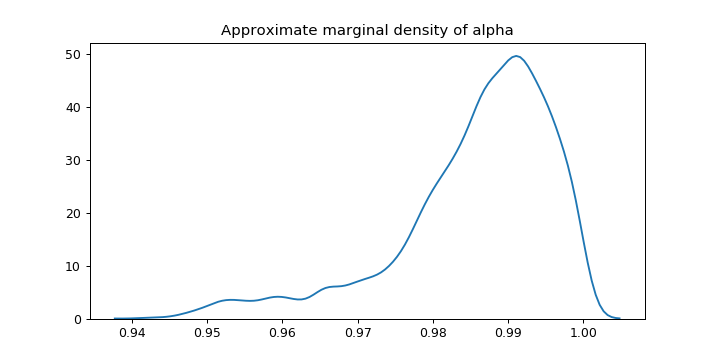

In [99]:
#alpha density

plt.rcParams['figure.figsize'] = [8,4]
for i in range(0,df_of_all_thetas.shape[0]):
    
    plt.figure()
    sns.kdeplot(df_of_all_thetas['All thetas'][i+1][:,1])
    
    title='Approximate marginal density of alpha'
    
    plt.title(title)
    plt.savefig(title+".png")
    

plt.show()

<IPython.core.display.Javascript object>


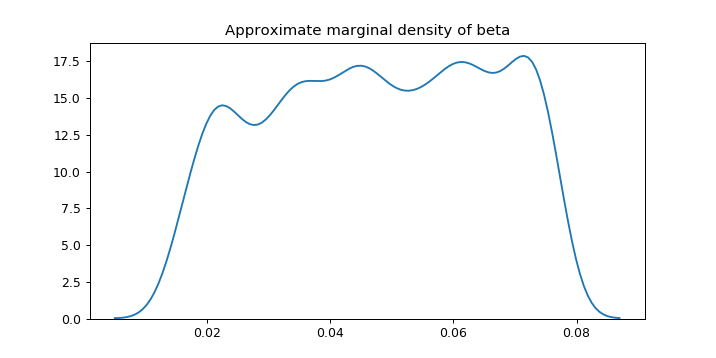

In [100]:
#beta density

plt.rcParams['figure.figsize'] = [8,4]
for i in range(0,df_of_all_thetas.shape[0]):
    
    plt.figure()
    sns.kdeplot(df_of_all_thetas['All thetas'][i+1][:,2])
    
    title='Approximate marginal density of beta'
    
    plt.title(title)
    plt.savefig(title+".png")
    
plt.show()


In [ ]:
GARCH_param

Define the normalized residuals as:
$$\widehat{\epsilon_t}=\dfrac{y_t}{\widehat{h}_t^{1/2}}$$

In [101]:
#We compute the normalized residuals defined above
#We first compute the conditional variance h_t valued at the mean of the posterior sample
h_mean_post_sample = h(posterior_mean_computations['avg omega value'][1],
                       posterior_mean_computations['avg alpha value'][1],
                       posterior_mean_computations['avg beta value'][1])

#initialize the normalized residuals
e_hat = np.empty(h_mean_post_sample.shape[0])

for obs in range(h_mean_post_sample.shape[0]):
        e_hat[obs] = logret[obs]/(h_mean_post_sample[obs]**0.5)
e_hat = e_hat.tolist()

In [102]:
#allows to display the following plots
%matplotlib inline

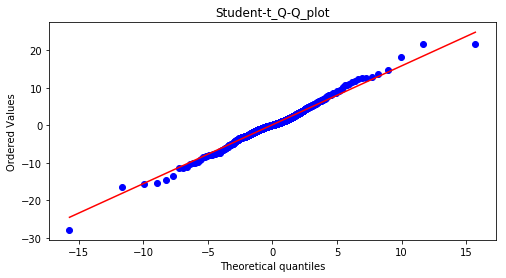

In [108]:
#https://data.library.virginia.edu/understanding-q-q-plots/
#"  A Q-Q plot is a scatterplot created by plotting two sets of quantiles against one another. 
#If both sets of quantiles came from the same distribution, 
#we should see the points forming a line that’s roughly straight. "

plt.rcParams['figure.figsize'] = [8,4]
stats.probplot(e_hat,sparams=3,dist="t", plot=plt)

title='Student-t_Q-Q_plot'

plt.title(title)
plt.savefig(title+".png")
plt.show()

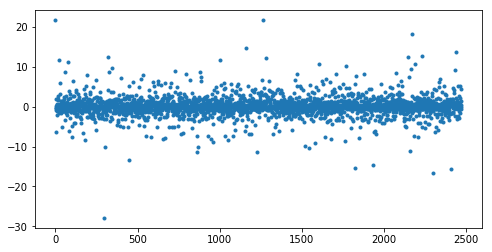

In [104]:
plt.rcParams['figure.figsize'] = [8,4]
plt.plot(e_hat,'.')
title='normalized_residuals_scatter_plot'
plt.savefig(title+".png")
plt.show()